# Predict Type2Diabetes

# Import Packages

In [110]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE,ADASYN
import lightgbm as lgm
from boruta import BorutaPy
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve,auc,log_loss
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as se
from sklearn.utils import shuffle
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

# Data Upload

In [111]:
medications = pd.read_csv('medications.csv',encoding='unicode_escape')
labs = pd.read_csv('labs.csv',encoding='unicode_escape')

# Data Pre-Processing

In [112]:
medications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20194 entries, 0 to 20193
Data columns (total 13 columns):
SEQN        20194 non-null int64
RXDUSE      20194 non-null int64
RXDDRUG     14100 non-null object
RXDDRGID    14016 non-null object
RXQSEEN     14019 non-null float64
RXDDAYS     14018 non-null float64
RXDRSC1     14022 non-null object
RXDRSC2     714 non-null object
RXDRSC3     127 non-null object
RXDRSD1     13633 non-null object
RXDRSD2     714 non-null object
RXDRSD3     127 non-null object
RXDCOUNT    14100 non-null float64
dtypes: float64(3), int64(2), object(8)
memory usage: 2.0+ MB


In [113]:
labs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9813 entries, 0 to 9812
Columns: 424 entries, SEQN to LBDB12SI
dtypes: float64(423), int64(1)
memory usage: 31.7 MB


In [114]:
medications.head()

,SEQN,RXDUSE,RXDDRUG,RXDDRGID,RXQSEEN,RXDDAYS,RXDRSC1,RXDRSC2,RXDRSC3,RXDRSD1,RXDRSD2,RXDRSD3,RXDCOUNT
0,73557,1,99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,73557,1,INSULIN,d00262,2.0,1460.0,E11,NaN,NaN,Type 2 diabetes mellitus,NaN,NaN,2.0
2,73558,1,GABAPENTIN,d03182,1.0,243.0,G25.81,NaN,NaN,Restless legs syndrome,NaN,NaN,4.0
3,73558,1,INSULIN GLARGINE,d04538,1.0,365.0,E11,NaN,NaN,Type 2 diabetes mellitus,NaN,NaN,4.0
4,73558,1,OLMESARTAN,d04801,1.0,14.0,E11.2,NaN,NaN,Type 2 diabetes mellitus with kidney complicat...,NaN,NaN,4.0


In [115]:
labs.head()

,SEQN,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,WTSAF2YR.x,LBXAPB,LBDAPBSI,LBXSAL,...,URXUTL,URDUTLLC,URXUTU,URDUTULC,URXUUR,URDUURLC,URXPREG,URXUAS,LBDB12,LBDB12SI
0,73557,4.3,4.3,39.0,3447.6,11.03,NaN,NaN,NaN,4.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,524.0,386.7
1,73558,153.0,153.0,50.0,4420.0,306.00,NaN,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,507.0,374.2
2,73559,11.9,11.9,113.0,9989.2,10.53,142196.890197,57.0,0.57,3.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,732.0,540.2
3,73560,16.0,16.0,76.0,6718.4,21.05,NaN,NaN,NaN,NaN,...,0.062,0.0,0.238,0.0,0.0071,0.0,NaN,3.83,NaN,NaN
4,73561,255.0,255.0,147.0,12994.8,173.47,142266.006548,92.0,0.92,4.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.0,166.1


Filter records in medications dataframe based on RXDDAYS

In [116]:
medications.sort_values('RXDDAYS',ascending=False,inplace=True)
medications.reset_index(inplace=True,drop=True)

In [117]:
medications = medications.drop_duplicates('SEQN',keep='first')

In [118]:
len(medications)

10175

In [119]:
medications.sort_values('SEQN',inplace=True)
medications.reset_index(inplace=True,drop=True)

Make target variable using medications dataframe

In [120]:
medications['is_diabetic'] = np.where(medications['RXDRSC1'].str.contains('E11',case=False,na=False),'1','0')

In [121]:
medications = medications.iloc[:,[0,13]]

In [122]:
diabetes = pd.merge(labs,medications,how='left',on='SEQN')

In [123]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9813 entries, 0 to 9812
Columns: 425 entries, SEQN to is_diabetic
dtypes: float64(423), int64(1), object(1)
memory usage: 31.9+ MB


In [124]:
diabetes.head()

,SEQN,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,WTSAF2YR.x,LBXAPB,LBDAPBSI,LBXSAL,...,URDUTLLC,URXUTU,URDUTULC,URXUUR,URDUURLC,URXPREG,URXUAS,LBDB12,LBDB12SI,is_diabetic
0,73557,4.3,4.3,39.0,3447.6,11.03,NaN,NaN,NaN,4.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,524.0,386.7,1
1,73558,153.0,153.0,50.0,4420.0,306.00,NaN,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,507.0,374.2,1
2,73559,11.9,11.9,113.0,9989.2,10.53,142196.890197,57.0,0.57,3.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,732.0,540.2,1
3,73560,16.0,16.0,76.0,6718.4,21.05,NaN,NaN,NaN,NaN,...,0.0,0.238,0.0,0.0071,0.0,NaN,3.83,NaN,NaN,0
4,73561,255.0,255.0,147.0,12994.8,173.47,142266.006548,92.0,0.92,4.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.0,166.1,0


Columns having more than 50% of null values will be deleted

In [125]:
diabetes.isna().sum()
diabetes.isna().mean()
diabetes = diabetes.loc[:,diabetes.isna().mean() <= .5]

In [126]:
len(diabetes.columns)

153

In [127]:
diabetes.head()

,SEQN,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,LBXSAL,LBDSALSI,LBXSAPSI,LBXSASSI,...,LBDBSESI,LBDBSELC,LBXBMN,LBDBMNSI,LBDBMNLC,URXVOL1,URDFLOW1,LBDB12,LBDB12SI,is_diabetic
0,73557,4.3,4.3,39.0,3447.6,11.03,4.1,41.0,129.0,16.0,...,NaN,NaN,NaN,NaN,NaN,87.0,0.821,524.0,386.7,1
1,73558,153.0,153.0,50.0,4420.0,306.00,4.7,47.0,97.0,18.0,...,2.60,0.0,8.15,148.33,0.0,90.0,1.636,507.0,374.2,1
2,73559,11.9,11.9,113.0,9989.2,10.53,3.7,37.0,99.0,22.0,...,2.66,0.0,9.57,174.17,0.0,66.0,NaN,732.0,540.2,1
3,73560,16.0,16.0,76.0,6718.4,21.05,NaN,NaN,NaN,NaN,...,2.16,0.0,13.07,237.87,0.0,61.0,0.575,NaN,NaN,0
4,73561,255.0,255.0,147.0,12994.8,173.47,4.3,43.0,78.0,36.0,...,NaN,NaN,NaN,NaN,NaN,5.0,0.109,225.0,166.1,0


Fill NaN values by using mean of the column

In [128]:
diabetes = diabetes.fillna(diabetes.mean())

In [129]:
diabetes.head()

,SEQN,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,LBXSAL,LBDSALSI,LBXSAPSI,LBXSASSI,...,LBDBSESI,LBDBSELC,LBXBMN,LBDBMNSI,LBDBMNLC,URXVOL1,URDFLOW1,LBDB12,LBDB12SI,is_diabetic
0,73557,4.3,4.3,39.0,3447.6,11.03,4.100000,41.000000,129.000000,16.000000,...,2.395314,0.0,10.506341,191.215396,0.0,87.0,0.821000,524.000000,386.700000,1
1,73558,153.0,153.0,50.0,4420.0,306.00,4.700000,47.000000,97.000000,18.000000,...,2.600000,0.0,8.150000,148.330000,0.0,90.0,1.636000,507.000000,374.200000,1
2,73559,11.9,11.9,113.0,9989.2,10.53,3.700000,37.000000,99.000000,22.000000,...,2.660000,0.0,9.570000,174.170000,0.0,66.0,0.907887,732.000000,540.200000,1
3,73560,16.0,16.0,76.0,6718.4,21.05,4.282085,42.820845,78.578907,25.117845,...,2.160000,0.0,13.070000,237.870000,0.0,61.0,0.575000,640.100263,472.394865,0
4,73561,255.0,255.0,147.0,12994.8,173.47,4.300000,43.000000,78.000000,36.000000,...,2.395314,0.0,10.506341,191.215396,0.0,5.0,0.109000,225.000000,166.100000,0


In [130]:
x = diabetes.iloc[:,:-1]

In [131]:
y = diabetes.iloc[:,[-1]]

# Feature Selection

Boruta

In [23]:
fields_ranking = pd.DataFrame(x.columns.tolist(), columns=['features'])
random_forest_classifier = RandomForestClassifier()
boruta = BorutaPy(random_forest_classifier,n_estimators='auto')
boruta.fit(x.values,y.values)
fields_ranking['rank'] = boruta.ranking_
fields_ranking.sort_values('rank',ascending=True,inplace=True)
fields_ranking.reset_index(inplace=True,drop=True)
print(boruta.n_features_)
fields_ranking.head(15)

5


,features,rank
0,URXUMA,1
1,LBXGH,1
2,URDACT,1
3,LBDSGLSI,1
4,LBXSGL,1
5,SEQN,2
6,URXUMS,3
7,LBXSOSSI,4
8,LBDB12SI,5
9,LBDB12,6


Lightgbm

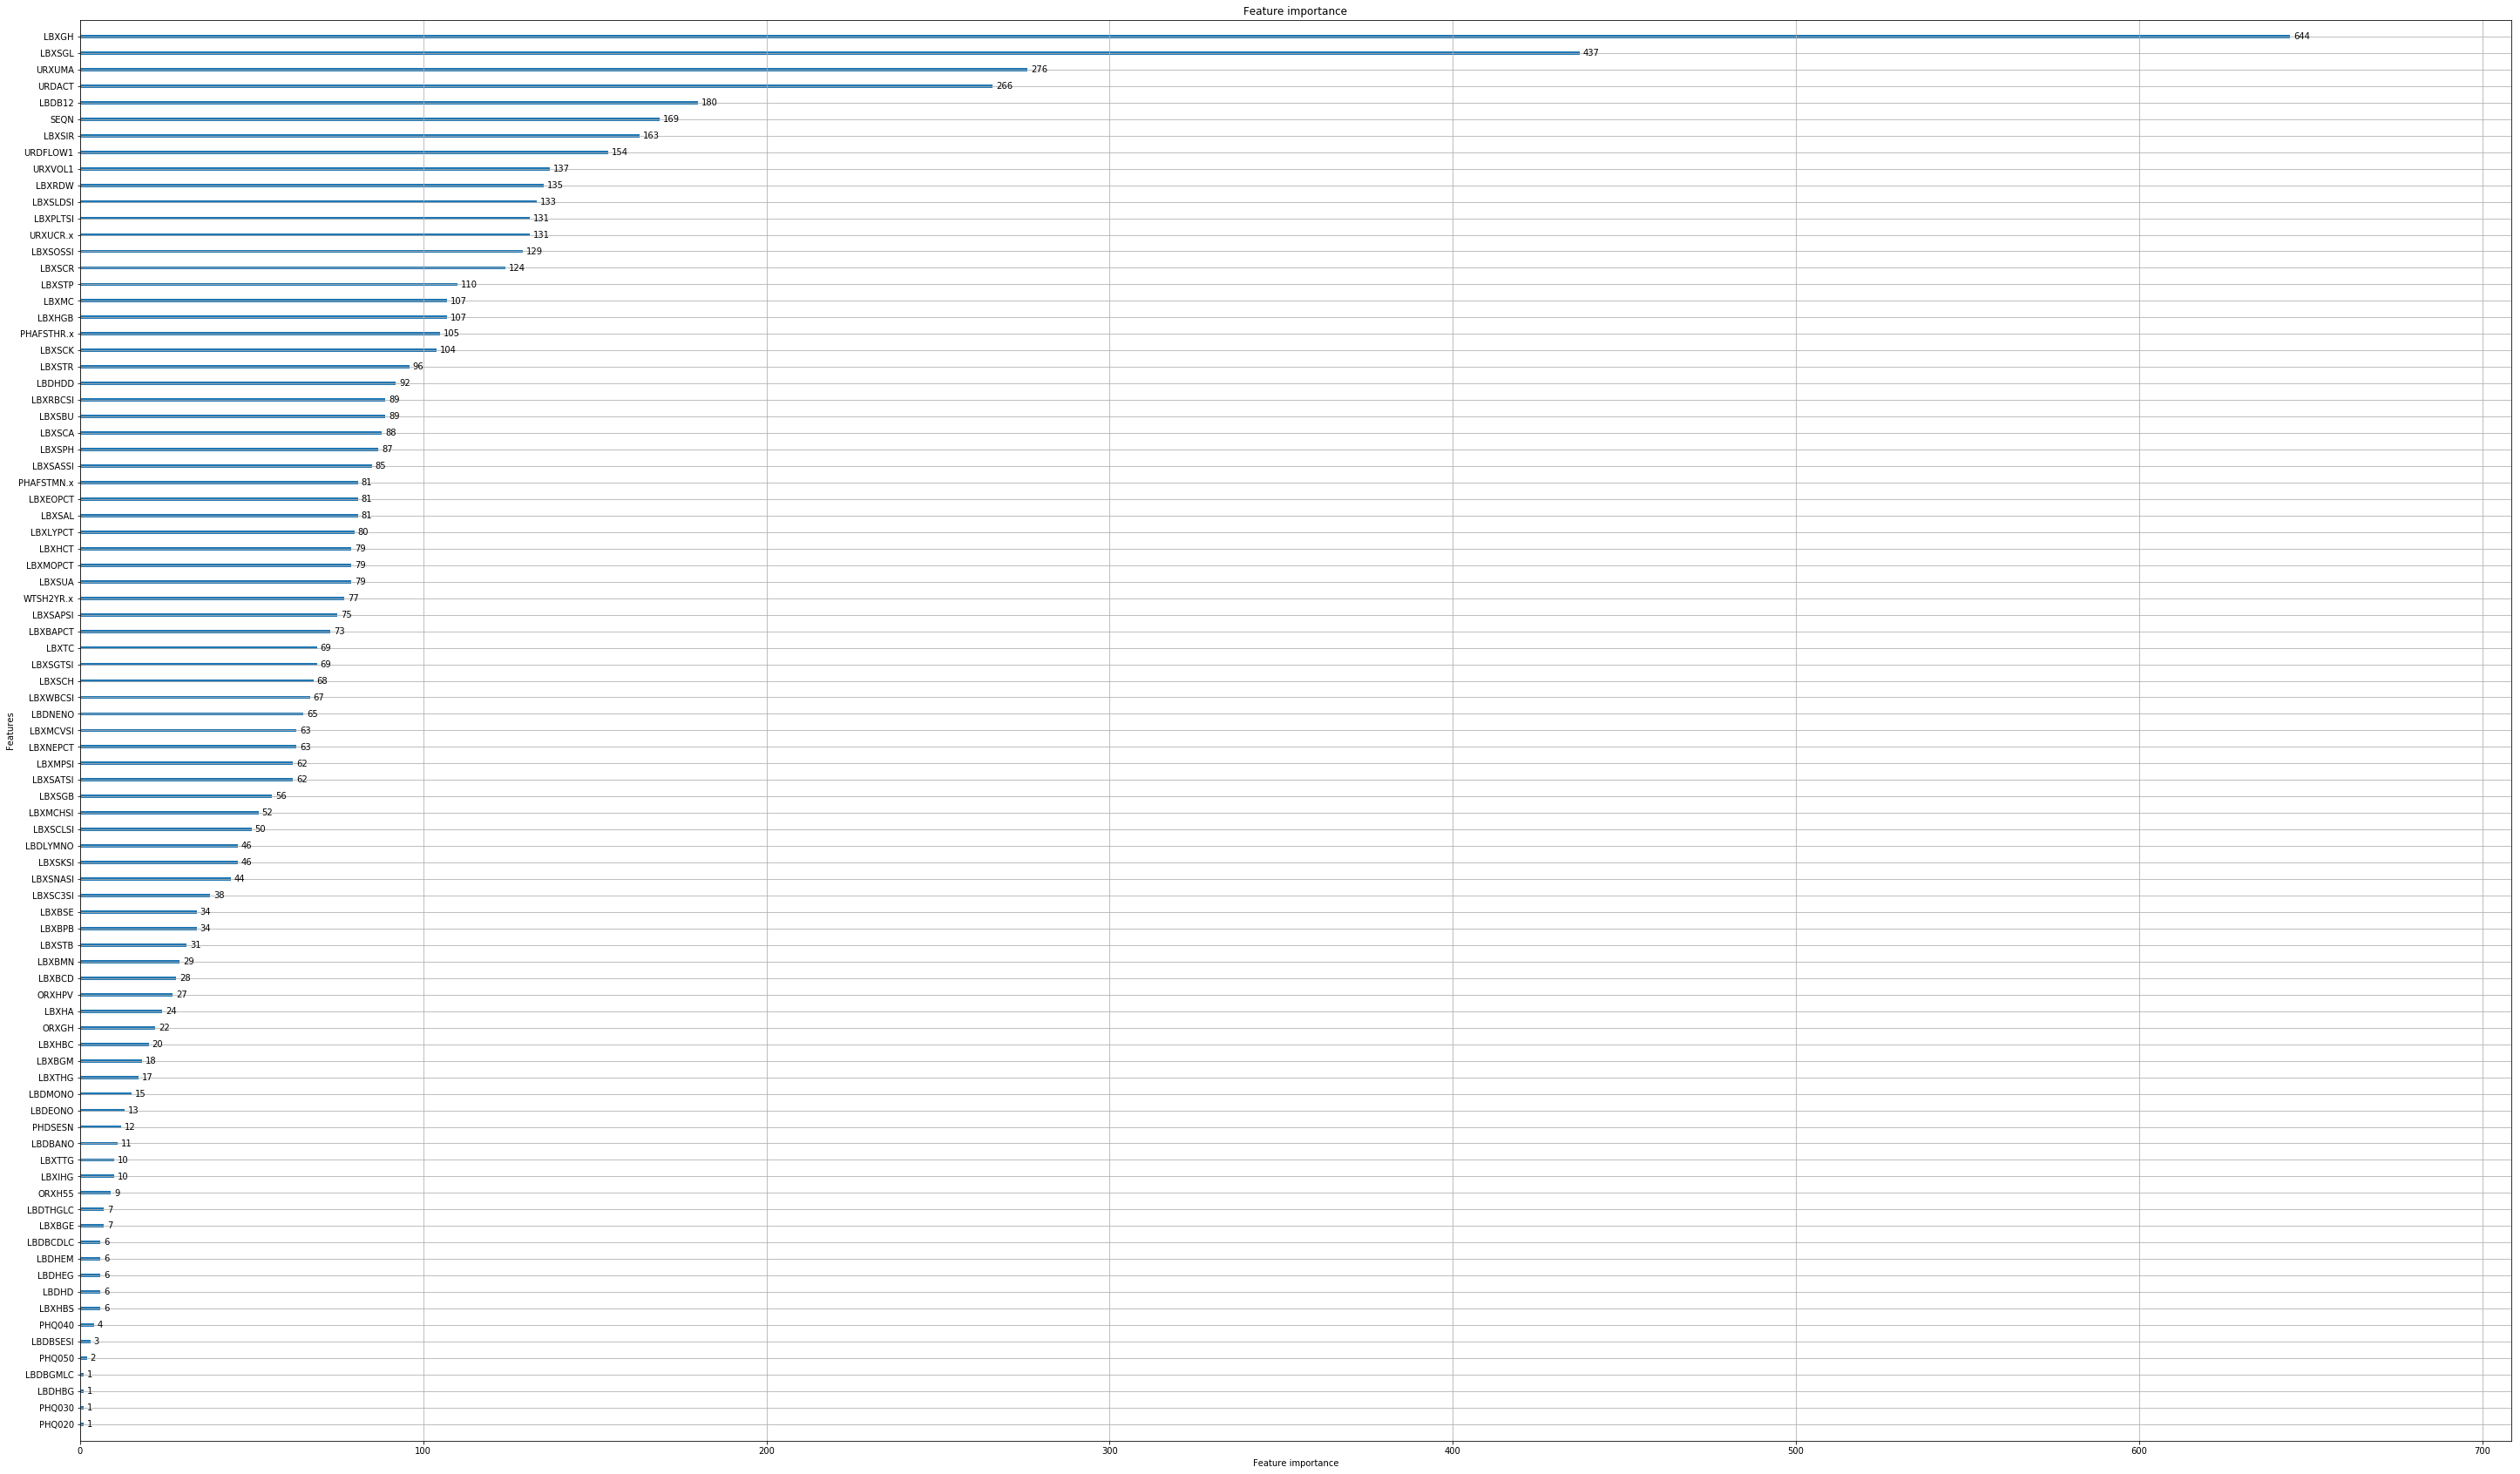

In [132]:
y['is_diabetic'] = y['is_diabetic'].astype(int)
data = lgm.Dataset(x,label=y)
params = {"max_depth":15, "learning_rate":0.1, "num_leaves":900, "n_estimators":100}
lgm_model = lgm.train(params=params, train_set=data, categorical_feature='auto')
lgm_plot = lgm.plot_importance(lgm_model, max_num_features=152, figsize=(50,30))
plt.show()

use lightgbm for selecting important features

In [133]:
this = list(lgm_model.feature_importance())
effe_cols = []
for i in this:
    if i > 110:
        effe_cols.append(lgm_model.feature_name()[this.index(i)])
        this[this.index(i)]=0
diabetes = diabetes[effe_cols]
diabetes['is_diabetic'] = y['is_diabetic']
del diabetes['SEQN']
diabetes.head()

,URXUMA,URXUCR.x,URDACT,LBXSCR,LBXSGL,LBXSIR,LBXSLDSI,LBXSOSSI,LBXRDW,LBXPLTSI,LBXGH,URXVOL1,URDFLOW1,LBDB12,is_diabetic
0,4.3,39.0,11.03,1.210000,554.000000,58.000000,118.00000,296.000000,14.0,204.0,13.900000,87.0,0.821000,524.000000,1
1,153.0,50.0,306.00,0.790000,219.000000,79.000000,122.00000,265.000000,13.4,314.0,9.100000,90.0,1.636000,507.000000,1
2,11.9,113.0,10.53,1.220000,183.000000,98.000000,134.00000,288.000000,13.4,237.0,8.900000,66.0,0.907887,732.000000,1
3,16.0,76.0,21.05,0.880172,102.290859,83.445534,126.80171,279.273615,13.7,240.0,5.642556,61.0,0.575000,640.100263,0
4,255.0,147.0,173.47,0.730000,104.000000,91.000000,201.00000,290.000000,12.3,300.0,4.900000,5.0,0.109000,225.000000,0


Description for features

# Exploratory Data Analysis

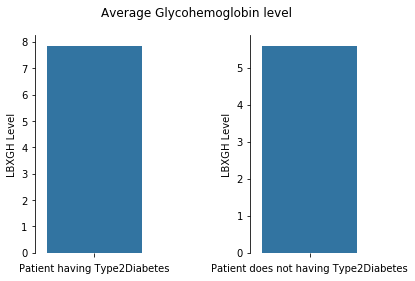

In [25]:
glycohemoglobin_level_t2d = pd.DataFrame(diabetes[diabetes['is_diabetic']==1].iloc[:,10],columns=['LBXGH'])
glycohemoglobin_level_t2d.sort_values('LBXGH',ascending=False,inplace=True)
glycohemoglobin_level_t2d.reset_index(inplace=True,drop=True)
glycohemoglobin_level_t2d = pd.DataFrame([glycohemoglobin_level_t2d['LBXGH'].mean()],columns=['LBXGH_Level'])
glycohemoglobin_level_normal = pd.DataFrame(diabetes[diabetes['is_diabetic']==0].iloc[:,10],columns=['LBXGH'])
glycohemoglobin_level_normal.sort_values('LBXGH',ascending=False,inplace=True)
glycohemoglobin_level_normal.reset_index(inplace=True,drop=True)
glycohemoglobin_level_normal = pd.DataFrame([glycohemoglobin_level_normal['LBXGH'].mean()],columns=['LBXGH_Level'])
f, (ax1,ax2) = plt.subplots(1, 2)
glycohemoglobin_t2d_plot = se.barplot(y=glycohemoglobin_level_t2d,ax=ax1)
glycohemoglobin_normal_plot = se.barplot(y=glycohemoglobin_level_normal,ax=ax2)
ax1.set_ylabel('LBXGH Level')
ax1.set_xlabel('Patient having Type2Diabetes')
ax2.set_ylabel('LBXGH Level')
ax2.set_xlabel('Patient does not having Type2Diabetes')
f.suptitle('Average Glycohemoglobin level')
f.subplots_adjust(wspace=0.8)
se.despine(bottom=True)

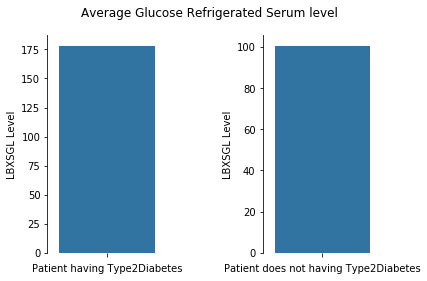

In [26]:
glucose_refrigerated_level_t2d = pd.DataFrame(diabetes[diabetes['is_diabetic']==1].iloc[:,4],columns=['LBXSGL'])
glucose_refrigerated_level_t2d.sort_values('LBXSGL',ascending=False,inplace=True)
glucose_refrigerated_level_t2d.reset_index(inplace=True,drop=True)
glucose_refrigerated_level_t2d = pd.DataFrame([glucose_refrigerated_level_t2d['LBXSGL'].mean()],columns=['LBXSGL_Level'])
glucose_refrigerated_level_normal = pd.DataFrame(diabetes[diabetes['is_diabetic']==0].iloc[:,4],columns=['LBXSGL'])
glucose_refrigerated_level_normal.sort_values('LBXSGL',ascending=False,inplace=True)
glucose_refrigerated_level_normal.reset_index(inplace=True,drop=True)
glucose_refrigerated_level_normal = pd.DataFrame([glucose_refrigerated_level_normal['LBXSGL'].mean()],columns=['LBXSGL_Level'])
f, (ax3,ax4) = plt.subplots(1, 2)
glucose_refrigerated_t2d_plot = se.barplot(y=glucose_refrigerated_level_t2d,ax=ax3)
glucose_refrigerated_normal_plot = se.barplot(y=glucose_refrigerated_level_normal,ax=ax4)
ax3.set_ylabel('LBXSGL Level')
ax3.set_xlabel('Patient having Type2Diabetes')
ax4.set_ylabel('LBXSGL Level')
ax4.set_xlabel('Patient does not having Type2Diabetes')
f.suptitle('Average Glucose Refrigerated Serum level')
f.subplots_adjust(wspace=0.8)
se.despine(bottom=True)

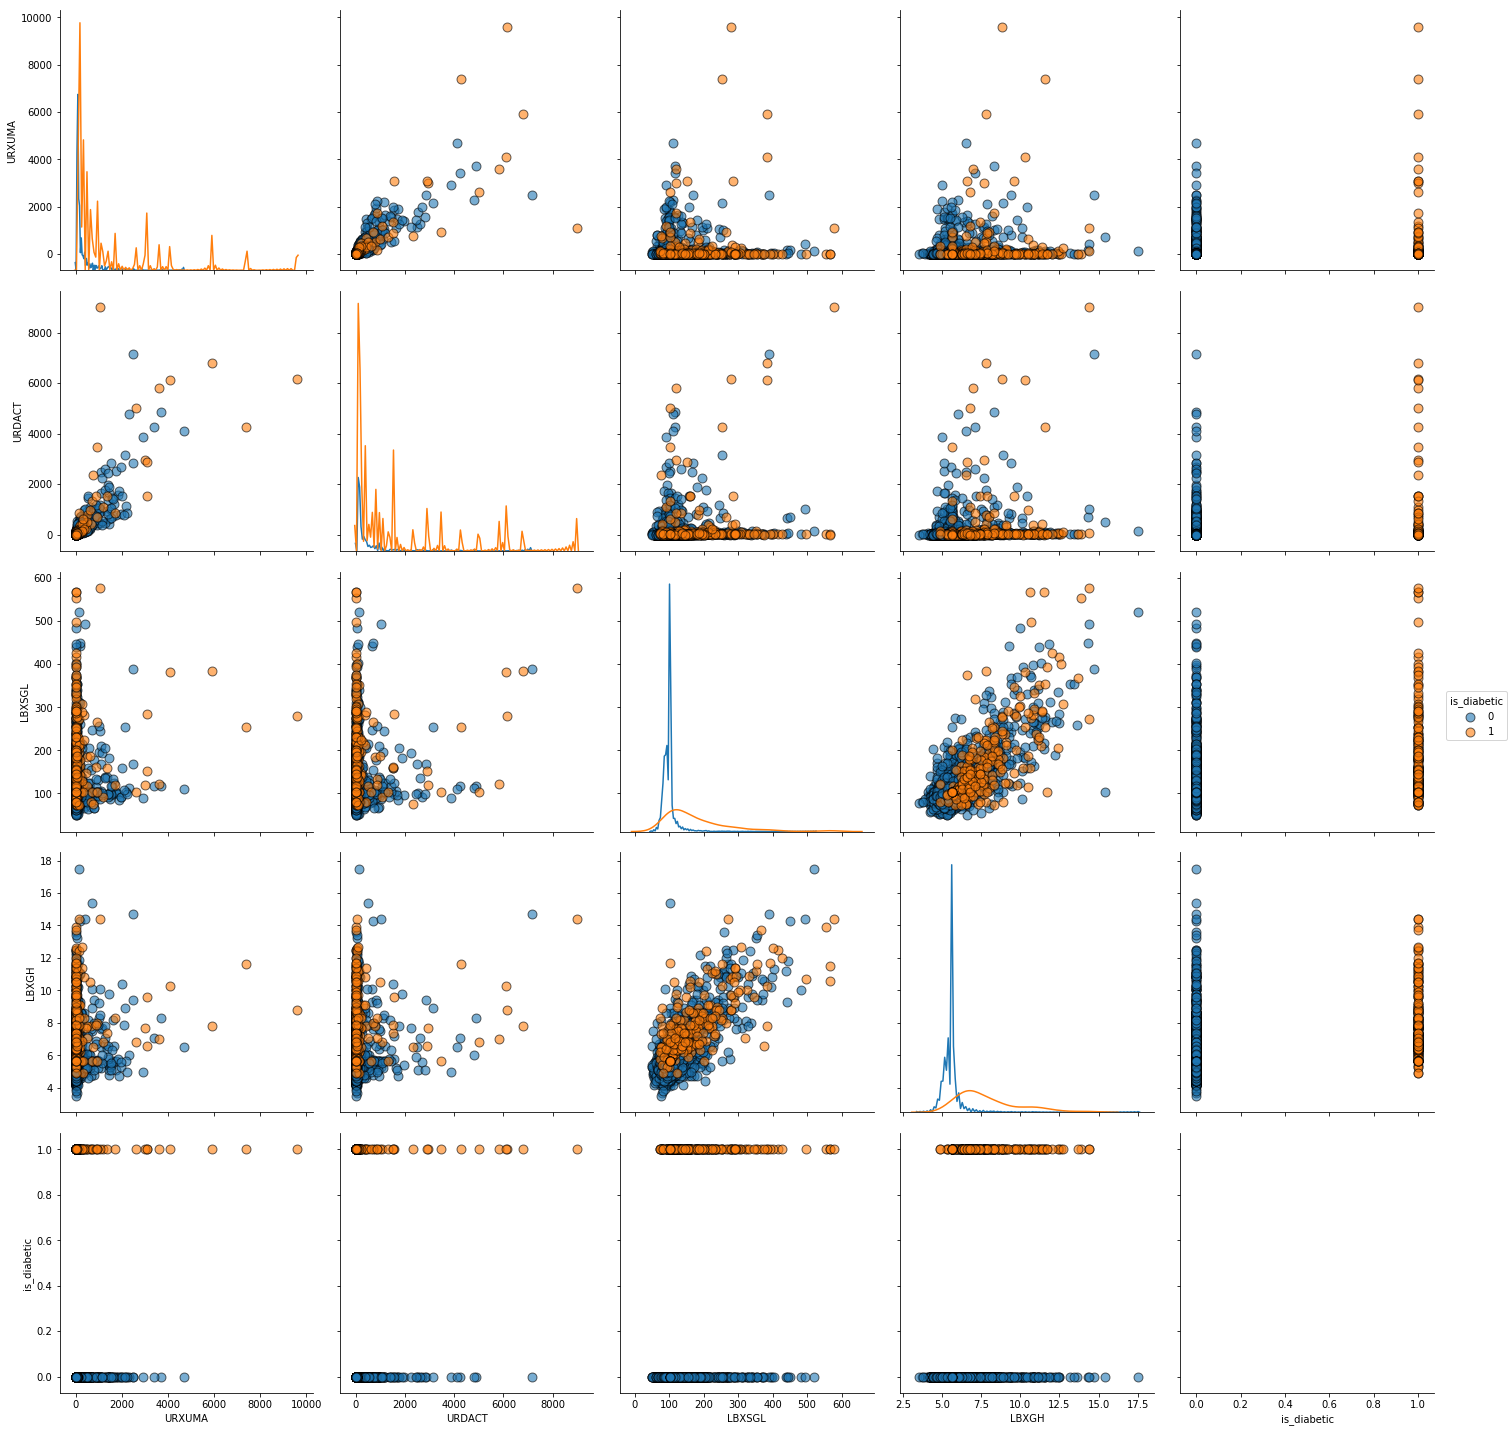

In [27]:
pairplot_t2d = se.pairplot(diabetes.iloc[:,[0,2,4,10,14]], hue='is_diabetic', diag_kind='kde', plot_kws={'alpha':0.6, 's':80, 'edgecolor':'k'}, size=4)

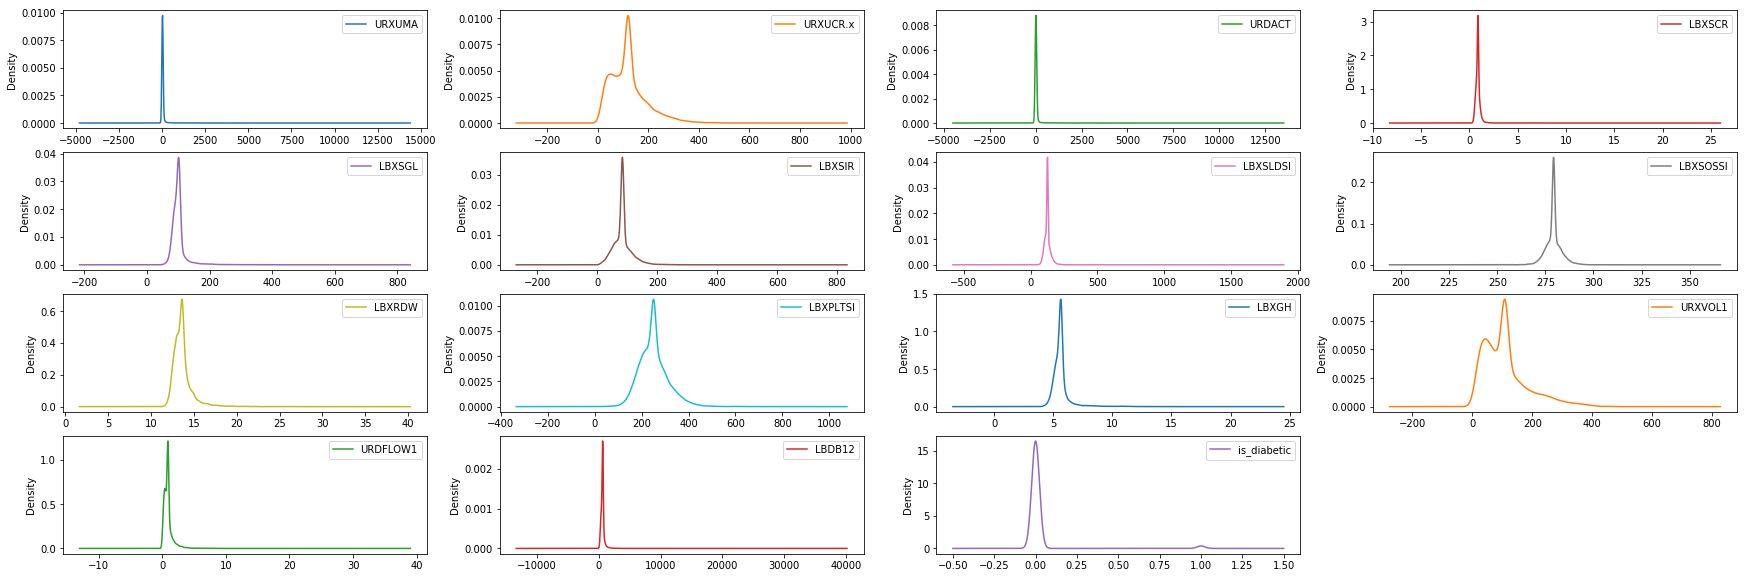

In [29]:
diabetes.plot(kind='density', subplots=True, layout=(4,4), sharex=False,figsize=(30,10))
plt.show()

# Features Correlation

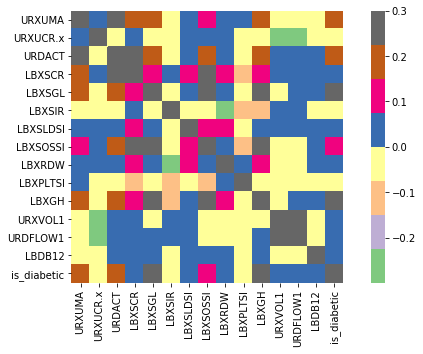

In [134]:
diabetes['is_diabetic'] = diabetes['is_diabetic'].astype(int)
feature_corr = diabetes.corr()
plt.subplots(figsize=(10,5))
feature_map = se.heatmap(feature_corr, cmap='Accent', center=0, vmax=.3, square=True)
plt.show()

should we check the balance of the dataset

In [135]:
diabetes.is_diabetic.value_counts()

0    9592
1     221
Name: is_diabetic, dtype: int64

# Balancing Data

In [136]:
x = diabetes.iloc[:,:-1]
y = diabetes.iloc[:,[-1]]
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values
y_train = y_train.values

SMOTE

In [137]:
synthetic_features_SMOTE = SMOTE(random_state=0,ratio={0:9592,1:1000})
X_SMOTE, Y_SMOTE = synthetic_features_SMOTE.fit_sample(x_train,y_train.ravel())
print(np.unique(Y_SMOTE,return_counts=True))

(array([0, 1]), array([9592, 1000], dtype=int64))


In [138]:
print("Length of X is", len(X_SMOTE))
print("Length of Y is", len(Y_SMOTE))

Length of X is 10592
Length of Y is 10592


ADASYN

In [139]:
synthetic_features_ADASYN = ADASYN(random_state=0, ratio={0:9592,1:1200})
X_ADASYN, Y_ADASYN = synthetic_features_ADASYN.fit_sample(x_train,y_train.ravel())
print(np.unique(Y_ADASYN,return_counts=True))

(array([0, 1]), array([9478, 1147], dtype=int64))


In [140]:
print("Length of X is", len(X_ADASYN))
print("Length of Y is", len(Y_ADASYN))

Length of X is 10625
Length of Y is 10625


# Model Selection

In [141]:
lr = LogisticRegression()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
xgbc = XGBClassifier()
model_list = []
model_list.append(('LR',lr))
model_list.append(('DTC',dtc))
model_list.append(('RFC',rfc))
model_list.append(('ABC',abc))
model_list.append(('GBC',gbc))
model_list.append(('xgbc',xgbc))
modelname = []
modelaccuracy = []
model_roc_auc_score = []
for model_name,select_model in model_list:
    fit_model = select_model.fit(X_ADASYN,Y_ADASYN)
    model_predict = fit_model.predict(x_test.values)
    model_accuracy = accuracy_score(y_test,model_predict)
    roc_auc_score_model = roc_auc_score(y_test,model_predict)
    model_msg = "%s %f %f" % (model_name, model_accuracy, roc_auc_score_model)
    modelname.append(model_name)
    modelaccuracy.append(model_accuracy)
    model_roc_auc_score.append(roc_auc_score_model)
    print(model_msg)

LR 0.976057 0.597132
DTC 0.956699 0.695731
RFC 0.974019 0.574389
ABC 0.967906 0.690615
GBC 0.967397 0.679504
xgbc 0.969435 0.691397


Text(0.5,1,'Accuracy of a model')

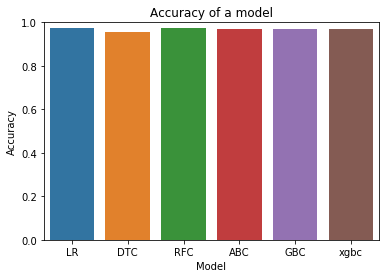

In [142]:
bar_plot = se.barplot(x=modelname,y=modelaccuracy)
bar_plot.set_ylim(0,1)
bar_plot.set_ylabel("Accuracy")
bar_plot.set_xlabel("Model")
bar_plot.set_title("Accuracy of a model")

# Model Evaluate

KFold Cross Validation

In [143]:
models = []
models.append(('LR',LogisticRegression()))
models.append(('DTC',DecisionTreeClassifier()))
models.append(('RFC',RandomForestClassifier()))
models.append(('ABC',AdaBoostClassifier()))
models.append(('GBC',GradientBoostingClassifier()))
models.append(('xgbc',XGBClassifier()))
model_results = []
model_name = []
model_score = []
for name, model in models:
    kfold_validation = model_selection.KFold(n_splits=10, random_state=0)
    cv_results = model_selection.cross_val_score(model, X_ADASYN, Y_ADASYN.ravel(), cv=kfold_validation, scoring='accuracy')
    model_results.append(cv_results)
    model_name.append(name)
    model_score.append(cv_results.mean())
    msg = "%s %f %f" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR 0.867525 0.262327
DTC 0.896247 0.174050
RFC 0.903866 0.232630
ABC 0.851994 0.253548
GBC 0.871293 0.247262
xgbc 0.866114 0.255561


(0.5, 1)

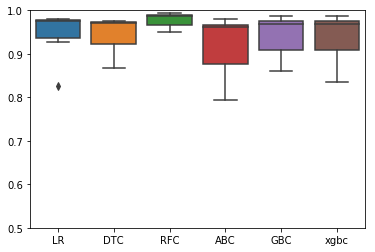

In [144]:
boxplot_cv = se.boxplot(x=model_name, y=model_results)
boxplot_cv.set_ylim(0.5,1)

# Model Tuning for RandomForestClassifier

In [41]:
rfc_tunning = RandomForestClassifier()

RandomizedSearchCV

In [77]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=11)]
max_depth.append(None)
min_samples_split = [2 ,5 ,10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True,False]
random_grid = {'n_estimators':n_estimators, 'max_features':max_features, 'max_depth':max_depth, 'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf, 'bootstrap':bootstrap}

In [78]:
randomsearch = RandomizedSearchCV(estimator=rfc_tunning, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
randomsearch.fit(X_ADASYN, Y_ADASYN)
randomsearch.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 21.9min finished


{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1800}

GridSearchCV

In [79]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [30, 40, 50, 60],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [1000, 1200, 1600, 2000]
}
gridsearch_tunning = GridSearchCV(estimator=rfc_tunning, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
gridsearch_tunning.fit(X_ADASYN, Y_ADASYN)
gridsearch_tunning.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 34.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 64.0min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 86.2min finished


{'bootstrap': False,
 'max_depth': 50,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

# Model Building for RandomForestClassifier

In [145]:
rfc_model = RandomForestClassifier(n_estimators=1000, max_depth=50, max_features='auto', bootstrap=False, min_samples_leaf=1, min_samples_split=2)
rfc_fit = rfc_model.fit(X_ADASYN, Y_ADASYN)
rfc_predict = rfc_fit.predict(x_test)
rfc_accuracy = accuracy_score(y_test,rfc_predict)
rfc_roc_score = roc_auc_score(y_test,rfc_predict)
rfc_predict_train_data = rfc_fit.predict(x_train)
rfc_accuracy_train_data = accuracy_score(y_train,rfc_predict_train_data)
rfc_roc_score_train_data = roc_auc_score(y_train, rfc_predict_train_data)
print("Accuracy on test data is %f" % (rfc_accuracy))
print("ROC_AUC Score for test data is %f" % (rfc_roc_score))
print("Accuracy on train data is %f" % (rfc_accuracy_train_data))
print("ROC_AUC Score for train data is %f" % (rfc_roc_score_train_data))

Accuracy on test data is 0.974529
ROC_AUC Score for test data is 0.563799
Accuracy on train data is 0.999745
ROC_AUC Score for train data is 0.994318


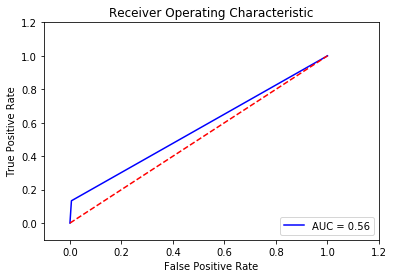

In [146]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,rfc_predict)
roc_auc = auc(false_positive_rate,true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [147]:
cm = confusion_matrix(y_test, rfc_predict)

In [148]:
cm

array([[1907,   11],
       [  39,    6]], dtype=int64)

# Model Tuning for AdaboostClassifier

In [45]:
abc_tuning = AdaBoostClassifier()

In [46]:
param_grid = {
    'n_estimators': [5,10],
    'learning_rate': [0.01,0.1,1]
}

RandomizedSearchCV

In [47]:
randomsearch = RandomizedSearchCV(estimator=abc_tuning, param_distributions=param_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
randomsearch.fit(X_ADASYN, Y_ADASYN)
randomsearch.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.8s finished


{'learning_rate': 1, 'n_estimators': 5}

GridSearchCV

In [48]:
gridsearch_tunning = GridSearchCV(estimator=abc_tuning, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
gridsearch_tunning.fit(X_ADASYN, Y_ADASYN)
gridsearch_tunning.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.4s finished


{'learning_rate': 1, 'n_estimators': 5}

# Model Building for AdaboostClassifier

In [149]:
dc_cl = DecisionTreeClassifier(max_depth=10, max_features=2,max_leaf_nodes=2,min_samples_leaf=1)
adboost_model = AdaBoostClassifier(learning_rate=1,n_estimators=5,base_estimator=dc_cl,random_state=0)
ad_fit = adboost_model.fit(X_ADASYN, Y_ADASYN)
ad_predict = ad_fit.predict(x_test)
ad_accuracy = accuracy_score(y_test,ad_predict)
ad_roc_auc = roc_auc_score(y_test,ad_predict)
ad_predict_train = ad_fit.predict(x_train)
ad_accuracy_train = accuracy_score(y_train,ad_predict_train)
ad_roc_auc_train = roc_auc_score(y_train,ad_predict_train)
print("Accuracy on test data is %f" % (ad_accuracy))
print("ROC_AUC Score for test data is %f" % (ad_roc_auc))
print("Accuracy on train data is %f" % (ad_accuracy_train))
print("ROC_AUC Score for train data is %f" % (ad_roc_auc_train))

Accuracy on test data is 0.945492
ROC_AUC Score for test data is 0.809350
Accuracy on train data is 0.953631
ROC_AUC Score for train data is 0.806963


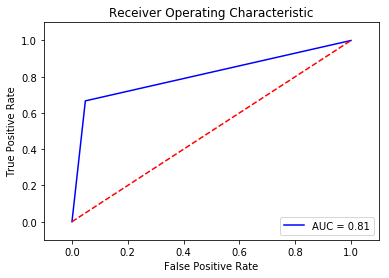

In [150]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,ad_predict)
roc_auc = auc(false_positive_rate,true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [151]:
cm =confusion_matrix(y_test,ad_predict)

In [152]:
cm

array([[1826,   92],
       [  15,   30]], dtype=int64)

# Model Tuning for DecisionTreeClassifier

In [53]:
max_depth = [int(x) for x in np.linspace(start=1, stop=32)]
max_features = list(range(1,diabetes.shape[1]))
min_samples_leaf = [1,2,3,4]
min_samples_split = [2,5,10]
param_grid_data = {
    'max_depth':max_depth,
    'max_features':max_features,
    'min_samples_leaf':min_samples_leaf,
    'min_samples_split':min_samples_split
}

GridsearchCV

In [82]:
gridsearch_tunning = GridSearchCV(estimator=dtc_tunning, param_grid=param_grid_data, cv=3, n_jobs=-1, verbose=2)
gridsearch_tunning.fit(X_ADASYN, Y_ADASYN)
gridsearch_tunning.best_params_

Fitting 3 folds for each of 9000 candidates, totalling 27000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 4852 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 8674 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 12353 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 17098 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 22883 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 27000 out of 27000 | elapsed:  4.0min finished


{'max_depth': 21,
 'max_features': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

# Model Building for DecisionTreeClassifier

In [54]:
decision_model = DecisionTreeClassifier(max_depth=30,max_features='auto',min_samples_leaf=1,min_samples_split=2,random_state=0,)
decision_fit = decision_model.fit(X_ADASYN, Y_ADASYN)
decision_predict = decision_fit.predict(x_test)
decision_accuracy = accuracy_score(y_test,decision_predict)
decision_roc_auc = roc_auc_score(y_test,decision_predict)
decision_predict_train = decision_fit.predict(x_train)
decision_accuracy_train = accuracy_score(y_train,decision_predict_train)
decision_roc_auc_train = roc_auc_score(y_train,decision_predict_train)
print("Accuracy on test data is %f" % (decision_accuracy))
print("ROC_AUC Score for test data is %f" % (decision_roc_auc))
print("Accuracy on train data is %f" % (decision_accuracy_train))
print("ROC_AUC Score for train data is %f" % (decision_roc_auc_train))

Accuracy on test data is 0.959246
ROC_AUC Score for test data is 0.697034
Accuracy on train data is 0.999745
ROC_AUC Score for train data is 0.994318


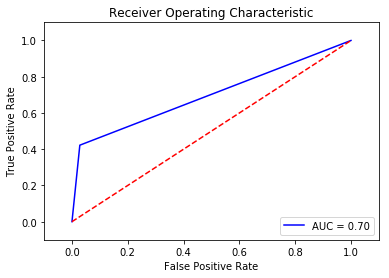

In [55]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,decision_predict)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate, 'b' ,label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [56]:
cm = confusion_matrix(y_test,decision_predict)

In [57]:
cm

array([[1864,   54],
       [  26,   19]], dtype=int64)

Create a pickle for Adaboost model

In [60]:
model_path = os.path.join(os.path.pardir,'Type2Diabetes','adaboost.pkl')
model_pickle = open(model_path,'wb')
pickle.dump(ad_fit,model_pickle)
model_pickle.close()

In [43]:
model_lr = os.path.join(os.path.pardir,'Type2Diabetes','lr.pkl')
model_pickle_lr = open(model_lr,'wb')
pickle.dump(lr,model_pickle_lr)
model_pickle_lr.close()

# User Input

In [153]:
type2Diabetes = pd.DataFrame()

In [258]:
print("Enter Albumin, urine (ug/mL)")
type2Diabetes.loc[0,'AlbuminUrine'] = float(input())

Enter Albumin, urine (ug/mL)
16


In [259]:
print("Enter Urinary creatinine (mg/dL)")
type2Diabetes.loc[0,'UrinaryCreatinine'] = float(input())

Enter Urinary creatinine (mg/dL)
76


In [260]:
print("Enter Albumin creatinine ratio (mg/g)")
type2Diabetes.loc[0,'AlbuminCreatinine'] = float(input())

Enter Albumin creatinine ratio (mg/g)
21.05


In [261]:
print("Enter Creatinine (mg/dL)")
type2Diabetes.loc[0,'Creatinine'] = float(input())

Enter Creatinine (mg/dL)
0.880172


In [262]:
print("Glucose, refrigerated serum (mg/dL)")
type2Diabetes.loc[0,'Glucose'] = float(input())

Glucose, refrigerated serum (mg/dL)
102.290859


In [263]:
print("Iron, refrigerated serum (ug/dL)")
type2Diabetes.loc[0,'Iron'] = float(input())

Iron, refrigerated serum (ug/dL)
83.445534


In [264]:
print("Lactate dehydrogenase (U/L)")
type2Diabetes.loc[0,'Lactate'] = float(input())

Lactate dehydrogenase (U/L)
126.80171


In [265]:
print("Osmolality (mmol/Kg)")
type2Diabetes.loc[0,'Osmolality'] = float(input())

Osmolality (mmol/Kg)
279.273615


In [266]:
print("Red cell distribution width (%)")
type2Diabetes.loc[0,'RedCell'] = float(input())

Red cell distribution width (%)
13.7


In [267]:
print("Platelet count (1000 cells/uL)")
type2Diabetes.loc[0,'Platelet'] = float(input())

Platelet count (1000 cells/uL)
240.0


In [268]:
print("Glycohemoglobin (%)")
type2Diabetes.loc[0,'Glycohemoglobin'] = float(input())

Glycohemoglobin (%)
5.642556


In [269]:
print("The volume of urine collection #1 (mL)")
type2Diabetes.loc[0,'UrineCollection'] = float(input())

The volume of urine collection #1 (mL)
61.0


In [270]:
print("Urine #1 Flow Rate (mL/min)")
type2Diabetes.loc[0,'UrineFlow'] = float(input())

Urine #1 Flow Rate (mL/min)
0.575000


In [271]:
print("Vitamin B12(pg/mL)")
type2Diabetes.loc[0,'VitaminB12'] = float(input())

Vitamin B12(pg/mL)
640.100263


# Predict

isDiabetic = No


Text(0.5,1,'Features Probability')

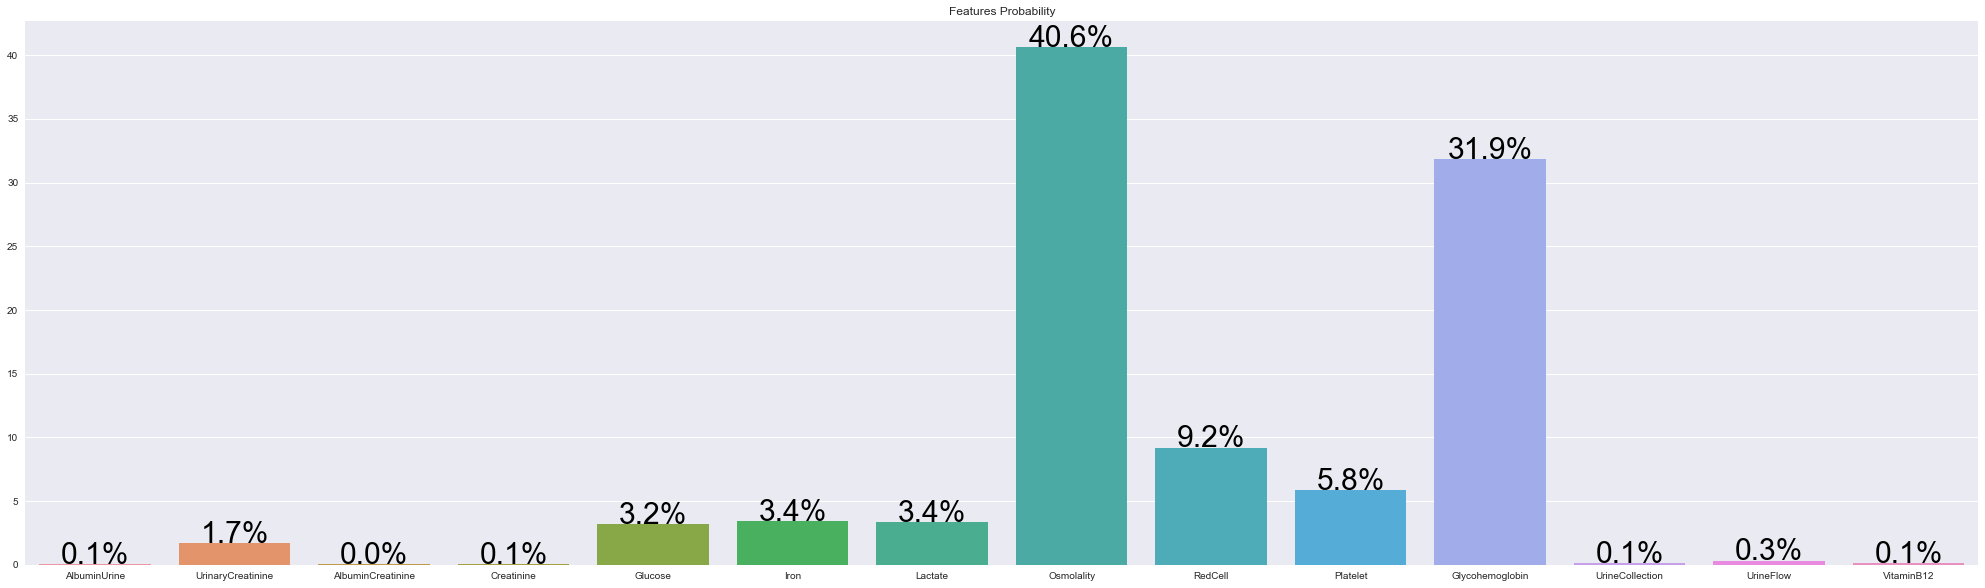

In [274]:
def total_weight_find(col_values, col_intercept):
    total_weight = 0
    for i in range(0, 14):
        total_weight = total_weight + (col_values[i]*col_intercept[0][i])
    return total_weight
predicted_data = ad_fit.predict(type2Diabetes.values.astype('float'))
if predicted_data==0:
    print("isDiabetic = No")
else:
    print("isDiabetic = Yes")
col_list = type2Diabetes.values.ravel().tolist()
intercept_values = lr.coef_.tolist()
total_weigh_data = total_weight_find(col_list, intercept_values)
w_glyco = ((col_list[10] * intercept_values[0][10]) / total_weigh_data)
w_gluco = ((col_list[4] * intercept_values[0][4]) / total_weigh_data)
w_albumin = ((col_list[0] * intercept_values[0][0]) / total_weigh_data)
w_alcr = ((col_list[2]*intercept_values[0][2]) / total_weigh_data)
w_uc = ((col_list[1]*intercept_values[0][1])/total_weigh_data)
w_cr = ((col_list[3]*intercept_values[0][3])/total_weigh_data)
w_ic = ((col_list[5]*intercept_values[0][5])/total_weigh_data)
w_ld = ((col_list[6]*intercept_values[0][6])/total_weigh_data)
w_os = ((col_list[7]*intercept_values[0][7])/total_weigh_data)
w_rd= ((col_list[8]*intercept_values[0][8])/total_weigh_data)
w_pl = ((col_list[9]*intercept_values[0][9])/total_weigh_data)
w_ucoll = ((col_list[11]*intercept_values[0][11])/total_weigh_data)
w_urflo = ((col_list[12]*intercept_values[0][12])/total_weigh_data)
w_vita = ((col_list[13]*intercept_values[0][13])/total_weigh_data)
total_pv = abs(w_glyco)+abs(w_gluco)+abs(w_alcr)+abs(w_albumin)+abs(w_uc)+abs(w_cr)+abs(w_ic)+abs(w_ld)+abs(w_os)+abs(w_rd)+abs(w_pl)+abs(w_ucoll)+abs(w_urflo)+abs(w_vita)
p_glyco = (w_glyco/total_pv)*100
p_gluco = (w_gluco/total_pv)*100
p_albumin = (w_albumin/total_pv)*100
p_alcr = (w_alcr/total_pv)*100
p_uc = (w_uc/total_pv)*100
p_cr = (w_cr/total_pv)*100
p_ic = (w_ic/total_pv)*100
p_ld = (w_ld/total_pv)*100
p_os = (w_os/total_pv)*100
p_rd = (w_rd/total_pv)*100
p_pl = (w_pl/total_pv)*100
p_ucoll = (w_ucoll/total_pv)*100
p_urflo = (w_urflo/total_pv)*100
p_vita = (w_vita/total_pv)*100
vb = [abs(round(p_albumin,2)),abs(round(p_uc,2)),abs(round(p_alcr,2)),abs(round(p_cr,2)),abs(round(p_gluco,2)),abs(round(p_ic,2)),abs(round(p_ld,2)),abs(round(p_os,2)),abs(round(p_rd,2)),abs(round(p_pl,2)),abs(round(p_glyco,2)),abs(round(p_ucoll,2)),abs(round(p_urflo,2)),abs(round(p_vita,2))]
plt.figure(figsize=(35,10))
dr = se.barplot(y=vb,x=type2Diabetes.columns)
k = 0
for p in dr.patches:
    dr.text(p.get_x()+p.get_width()/2.,
    p.get_height()+0.02,
    '{:1.1f}%'.format(vb[k]),
    ha="center",color='black',fontsize=30)
    k = k+1
plt.savefig('t2dColumnProbability.png')
plt.title("Features Probability")